In [100]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import warnings
import math
import numpy as np
import seaborn as sns
warnings.filterwarnings("ignore")

%matplotlib inline

In [101]:
## Functions

# Funktion, um den Wattwert für einen Prozess aus der 'processes'-Liste zu extrahieren
def extract_wattage(process_list, target_process):
    process_list = ast.literal_eval(process_list)
    for process, wattage in process_list:
        if process == target_process:
            return wattage
    return None

# Funktion um aus allen Messungen (W) den Energie Gesamt Energie-Verbrauch (KwH) für einen Service zu berechnen
def calculate_energy_consumption(process_name,process_wattage_slice,time_delta_slice):
    total_ws = 0.0
    total_t = 0

    for i in range(1,len(process_wattage_slice)):
        dt = time_delta_slice.iloc[i] - time_delta_slice.iloc[i-1]
        average = (process_wattage_slice.iloc[i] + process_wattage_slice.iloc[i-1]) / 2
        total_ws += average * dt
        total_t += dt
    
    if math.isnan(total_ws):
        return 0.0
    
    return total_ws
    

In [102]:
exp = "baseline_vanilla"

# Load data
from glob import glob
runs = glob(f"data/{exp}/*")

   requests  failures  med. lat.    avg. lat.     avg. size
7      2598       220         31  1196.771927  97757.724788 
     avg_wattage  avg_wattage_per_request
0  13327.379047              2369.558891
1   4530.322200               805.474596
2  13327.379047              2369.558891
3   4530.322200               805.474596
4  13327.379047              2369.558891
5  13327.379047              2369.558891
6  13327.379047              2369.558891 
total runtime: 461.914828 
req/s: 5.624413512007889
   requests  failures  med. lat.   avg. lat.    avg. size
6       121       115       66.0  334.105607  5922.297521 
    avg_wattage  avg_wattage_per_request
0  9742.989610             37202.752066
1  2468.946155              9427.454545
2  7672.082190             29295.173554
3  2468.946155              9427.454545
4  7672.082190             29295.173554
5  9742.989610             37202.752066
6  7672.082190             29295.173554 
total runtime: 462.027897 
req/s: 0.26188894823379033
   r

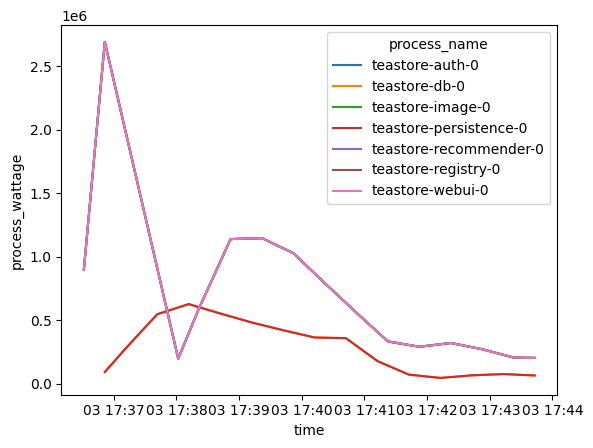

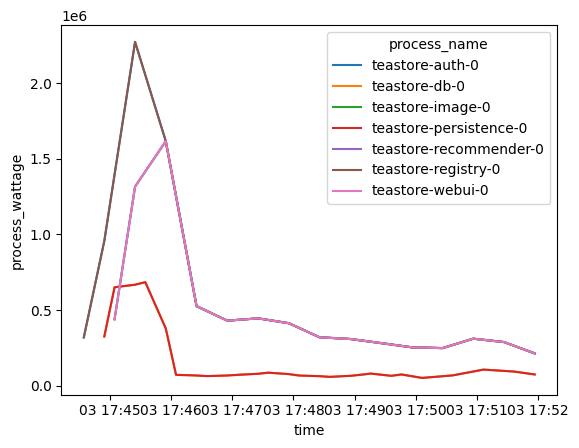

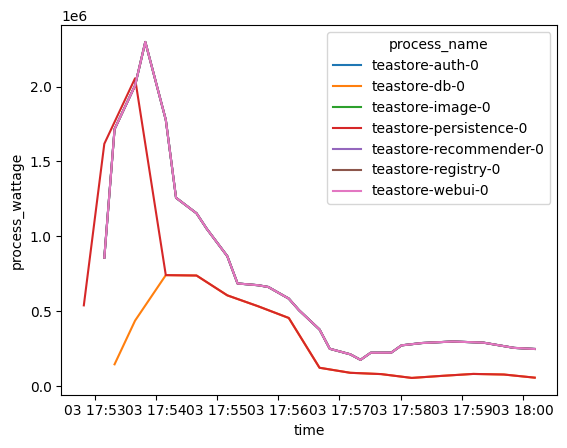

In [114]:
for run in runs:
    workload = pd.read_csv(f"{run}/locost_stats.csv").tail(1)[["Request Count", "Failure Count","Median Response Time","Average Response Time","Average Content Size"]].rename(
        columns={"Request Count": "requests", "Failure Count": "failures", "Median Response Time": "med. lat.", "Average Response Time": "avg. lat.", "Average Content Size": "avg. size"}
    )
    num_requests = workload["requests"].values[0]
    
    obversations = pd.read_csv(glob(f"{run}/measurements_*.csv")[0])
    obversations["time"] = pd.to_datetime(obversations["timestamp"])
    obversations["processes"] = obversations["processes"].apply(lambda x: ast.literal_eval(x))
    total_runtime = (obversations["time"].max()-obversations["time"].min()).total_seconds()
    X = obversations.explode("processes").dropna()
    X["process_name"] = X["processes"].apply(lambda x: x[0])
    X["wattage"] = X["processes"].apply(lambda x: x[1])
    process_stats = X.groupby("process_name")["process_wattage"].sum().reset_index().rename(columns={"process_wattage": "total_wattage"})

    process_stats["avg_wattage"] = process_stats["total_wattage"]/total_runtime
    process_stats["avg_wattage_per_request"] = process_stats["total_wattage"]/num_requests

    process_measures = X.groupby("process_name").rolling("60s",on="time")["process_wattage"].sum()
    # print summary
    print(workload, "\n",process_stats[["avg_wattage","avg_wattage_per_request"]], "\ntotal runtime:",total_runtime,"\nreq/s:",workload["requests"].values[0]/total_runtime)
    plt.figure()
    sns.lineplot(data=process_measures.reset_index(),x="time",y="process_wattage",hue="process_name")


2598